# Music genre prediction

## Вводная информация

### Описание задачи

Вы сотрудник Отдела Data Science популярного музыкального стримингового сервиса "МиФаСоль". Сервис расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача -- правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. Ваши коллеги из отдела работы со звуком подготовили датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры. Ваша задача -- разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

### Этапы работы

* загрузка и ознакомление с данными,
* предварительная обработка,
* полноценный разведочный анализ,
* разработка новых синтетических признаков,
* проверка на мультиколлинеарность,
* отбор финального набора обучающих признаков,
* выбор и обучение моделей,
* итоговая оценка качества предсказания лучшей модели,
* анализ важности ее признаков.

### Данные

* train.csv - информация (~20000) музыкальных треках, которые будут использоваться в качестве обучающих данных.
* test.csv - информация (~5000) музыкальных треках, которые будут использоваться в качестве тестовых данных. Ваша задача - предсказать значение * 'music_genre' для каждого трека из этого датасета.
* sample_submit.csv - файл предсказаний в правильном формате.
* instance_id - идентификатор трека в тестовом наборе.
* music_genre - Целевой признак. Для каждого трека предскажите категориальное значение соответствующее музыкальному жанру трека.

### Описание полей данных

* instance_id - уникальный идентификатор трека
* track_name - название трека
* acousticness - акустичность 
* danceability - танцевальность
* duration_ms -продолжительность в милисекундах
* energy - энергичность
* instrumentalness - инструментальность
* key - тональность
* liveness - привлекательность
* loudness - громкость
* mode - наклонение
* speechiness - выразительность
* tempo - темп
* obtained_date - дата загрузки в сервис
* valence - привлекательность произведения для пользователей сервиса
* music_genre - музыкальный жанр

## Предподготовка данных

### Загрузка и изучение данных

In [199]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
from phik.report import plot_correlation_matrix
from phik import report
import seaborn as sns


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, f1_score, precision_recall_curve,
                             precision_score, recall_score, roc_auc_score,
                             roc_curve, accuracy_score)
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config

In [153]:
train = pd.read_csv('kaggle_music_genre_train.csv')
test = pd.read_csv('kaggle_music_genre_test.csv')
submit = pd.read_csv('sample_submit.csv')

In [154]:
train.head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,25143.0,Highwayman,0.4800,0.670,182653.0,0.351,0.017600,D,0.115,-16.842,Major,0.0463,101.384,4-Apr,0.450,Country
1,26091.0,Toes Across The Floor,0.2430,0.452,187133.0,0.670,0.000051,A,0.108,-8.392,Minor,0.0352,113.071,4-Apr,0.539,Rock
2,87888.0,First Person on Earth,0.2280,0.454,173448.0,0.804,0.000000,E,0.181,-5.225,Minor,0.3710,80.980,4-Apr,0.344,Alternative
3,77021.0,No Te Veo - Digital Single,0.0558,0.847,255987.0,0.873,0.000003,G#,0.325,-4.805,Minor,0.0804,116.007,4-Apr,0.966,Hip-Hop
4,20852.0,Chasing Shadows,0.2270,0.742,195333.0,0.575,0.000002,C,0.176,-5.550,Major,0.0487,76.494,4-Apr,0.583,Alternative


In [155]:
test.head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence
0,48564,Low Class Conspiracy,0.301000,0.757,146213.0,0.679,0.00000,A#,0.3030,-7.136,Minor,0.3560,90.361,4-Apr,0.895
1,72394,The Hunter,0.538000,0.256,240360.0,0.523,0.00832,G#,0.0849,-5.175,Major,0.0294,78.385,4-Apr,0.318
2,88081,Hate Me Now,0.005830,0.678,284000.0,0.770,0.00000,A,0.1090,-4.399,Minor,0.2220,90.000,4-Apr,0.412
3,78331,Somebody Ain't You,0.020300,0.592,177354.0,0.749,0.00000,B,0.1220,-4.604,Major,0.0483,160.046,4-Apr,0.614
4,72636,Sour Mango,0.000335,0.421,-1.0,0.447,0.01480,D,0.0374,-8.833,Major,0.2020,73.830,4-Apr,0.121


In [156]:
submit.head()

,instance_id,music_genre
0,48564,Hip-Hop
1,72394,Alternative
2,88081,Rap
3,78331,Anime
4,72636,Anime


In [157]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

In [158]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       5099 non-null   int64  
 1   track_name        5099 non-null   object 
 2   acousticness      5099 non-null   float64
 3   danceability      5099 non-null   float64
 4   duration_ms       5099 non-null   float64
 5   energy            5099 non-null   float64
 6   instrumentalness  5099 non-null   float64
 7   key               4941 non-null   object 
 8   liveness          5099 non-null   float64
 9   loudness          5099 non-null   float64
 10  mode              4950 non-null   object 
 11  speechiness       5099 non-null   float64
 12  tempo             4978 non-null   float64
 13  obtained_date     5099 non-null   object 
 14  valence           5099 non-null   float64
dtypes: float64(10), int64(1), object(4)
memory usage: 597.7+ KB


In [159]:
submit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   instance_id  5099 non-null   int64 
 1   music_genre  5099 non-null   object
dtypes: int64(1), object(1)
memory usage: 79.8+ KB


In [160]:
train.isna().sum()

instance_id           0
track_name            0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 735
liveness              0
loudness              0
mode                506
speechiness           0
tempo               442
obtained_date         0
valence               0
music_genre           0
dtype: int64

In [161]:
test.isna().sum()

instance_id           0
track_name            0
acousticness          0
danceability          0
duration_ms           0
energy                0
instrumentalness      0
key                 158
liveness              0
loudness              0
mode                149
speechiness           0
tempo               121
obtained_date         0
valence               0
dtype: int64

### Работа с пропусками и дибликатами

In [162]:
# отобразим строки где имеюся пропуски в стобцax 'key', 'mode' и 'tempo'
train[train['key'].isnull()].head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
26,87453.0,"Serenade in B flat, K.361 ""Gran partita"": 3. A...",0.9910,0.154,-1.0,0.0384,0.902000,NaN,0.109,-26.909,Major,0.0405,68.199,4-Apr,0.0393,Classical
49,87796.0,Star67,0.7470,0.478,294973.0,0.3950,0.000005,NaN,0.264,-7.917,Major,0.2130,74.515,3-Apr,0.1700,Hip-Hop
60,69398.0,Sleep On The Floor,0.2490,0.389,211851.0,0.4310,0.000000,NaN,0.130,-8.061,Major,0.0344,142.140,4-Apr,0.2750,Rock
75,20134.0,Rogue,0.0145,0.580,201694.0,0.7200,0.598000,NaN,0.281,-5.541,Major,0.0638,143.816,4-Apr,0.1600,Electronic
107,69505.0,Party Song,0.1560,0.563,191760.0,0.8970,0.000000,NaN,0.352,-4.996,Major,0.2130,157.803,4-Apr,0.7790,Country


In [163]:
train[train['mode'].isnull()].head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
96,63867.0,"Clarinet Concerto No. 1 in F Minor, Op. 73, J....",0.973000,0.416,401000.0,0.0735,0.710000,F,0.0781,-20.723,NaN,0.0411,112.006,4-Apr,0.222,Classical
129,75913.0,"Concerto for Viola d'amore, Lute, Strings and ...",0.926000,0.495,-1.0,0.1110,0.120000,C#,0.0772,-18.591,NaN,0.0506,78.772,4-Apr,0.436,Classical
131,64391.0,She Keeps The Home Fires Burning,0.526000,0.731,236173.0,0.6080,0.000000,G,0.1260,-10.690,NaN,0.0267,126.263,4-Apr,0.745,Country
292,37649.0,Ven - Continuous Mix,0.000216,0.555,50472.0,0.9530,0.059400,E,0.8180,-4.411,NaN,0.1090,114.885,4-Apr,0.303,Electronic
326,43825.0,Wicked As It Seems,0.287000,0.689,285263.0,0.6200,0.000002,G,0.0368,-10.601,NaN,0.0339,110.860,4-Apr,0.962,Blues


In [164]:
train[train['tempo'].isnull()].head()

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
63,45966.0,Back Door Man,0.287000,0.476,212427.0,0.612,0.000252,A,0.0877,-7.010,Major,0.0335,NaN,4-Apr,0.909,Rock
85,90217.0,familia,0.000059,0.489,269000.0,0.947,0.000000,C#,0.1130,-3.925,Minor,0.0419,NaN,4-Apr,0.517,Anime
114,79170.0,Poor Johnny,0.348000,0.698,362267.0,0.800,0.000087,B,0.4430,-3.091,Minor,0.0284,NaN,4-Apr,0.654,Blues
138,39716.0,Set Free (feat. Yael),0.008340,0.776,191210.0,0.783,0.044900,C,0.0377,-3.595,Major,0.0374,NaN,4-Apr,0.943,Electronic
145,48590.0,Running Away,0.001100,0.608,178440.0,0.801,0.000008,A,0.2230,-5.452,Minor,0.0376,NaN,3-Apr,0.544,Alternative


In [165]:
train['key'] = train['key'].fillna('unknown')
train['mode'] = train['mode'].fillna('unknown')
train = train.dropna(subset=['tempo'])

test['key'] = test['key'].fillna('unknown')
test['mode'] = test['mode'].fillna('unknown')
test = test.dropna(subset=['tempo'])

In [166]:
print(train.isna().sum())
print(test.isna().sum())

instance_id         0
track_name          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
obtained_date       0
valence             0
music_genre         0
dtype: int64
instance_id         0
track_name          0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
obtained_date       0
valence             0
dtype: int64


In [167]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
instance_id,19952.0,55950.664495,20710.532430,20011.00000,38085.00000,56010.500000,73908.250000,91758.000
acousticness,19952.0,0.275090,0.321789,0.00000,0.01520,0.121000,0.471000,0.996
danceability,19952.0,0.562050,0.171902,0.06000,0.45100,0.570000,0.683000,0.978
duration_ms,19952.0,220282.559242,126445.462723,-1.00000,177307.00000,219507.000000,265975.000000,4497994.000
energy,19952.0,0.625111,0.251307,0.00101,0.47000,0.666000,0.830000,0.999
instrumentalness,19952.0,0.160307,0.306788,0.00000,0.00000,0.000146,0.084800,0.996
liveness,19952.0,0.198588,0.166603,0.01360,0.09730,0.130000,0.253000,1.000
loudness,19952.0,-8.552242,5.490332,-44.40600,-10.26325,-7.054500,-5.053750,3.744
speechiness,19952.0,0.091362,0.097772,0.02230,0.03560,0.049100,0.095525,0.942
tempo,19952.0,120.942522,30.427590,34.76500,95.92175,120.012500,141.966250,220.041


In [168]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
instance_id,4978.0,55712.007834,20758.967140,20012.000000,37675.500000,55440.500000,73733.250000,91709.000
acousticness,4978.0,0.276612,0.322915,0.000002,0.016525,0.120000,0.462000,0.996
danceability,4978.0,0.562235,0.170183,0.059600,0.451000,0.568000,0.681000,0.977
duration_ms,4978.0,217369.795299,115637.577578,-1.000000,173676.250000,217420.000000,264257.000000,1360027.000
energy,4978.0,0.622069,0.251630,0.001540,0.465000,0.660000,0.826000,0.999
instrumentalness,4978.0,0.165318,0.311876,0.000000,0.000000,0.000163,0.093475,0.994
liveness,4978.0,0.198026,0.166111,0.020400,0.097100,0.129000,0.249000,0.990
loudness,4978.0,-8.630047,5.611540,-46.122000,-10.238500,-7.135000,-5.136250,1.949
speechiness,4978.0,0.092159,0.099132,0.022600,0.035600,0.048500,0.095800,0.918
tempo,4978.0,121.246463,29.875950,37.114000,96.070250,120.053500,141.934250,216.029


In [169]:
# удалим строки где переменная 'duration_ms' имеет значение 0 и меньше
train = train[train['duration_ms'] > 0]
train = train[train['duration_ms'] < 2_000_000]
test = test[test['duration_ms'] > 0]

In [170]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
instance_id,17982.0,55982.526638,20711.964267,20011.00000,38128.75000,56048.500000,73936.500000,91758.000
acousticness,17982.0,0.274522,0.321558,0.00000,0.01490,0.121000,0.469000,0.996
danceability,17982.0,0.561763,0.171839,0.06000,0.45100,0.570000,0.682000,0.978
duration_ms,17982.0,243773.810533,97915.319817,15509.00000,191836.75000,226970.500000,272627.000000,1778440.000
energy,17982.0,0.626274,0.251595,0.00101,0.47100,0.667000,0.833000,0.999
instrumentalness,17982.0,0.161429,0.307755,0.00000,0.00000,0.000156,0.088400,0.996
liveness,17982.0,0.198885,0.166915,0.01360,0.09740,0.130000,0.254000,1.000
loudness,17982.0,-8.542760,5.489682,-44.40600,-10.25725,-7.042000,-5.042000,3.744
speechiness,17982.0,0.091175,0.097615,0.02230,0.03560,0.049000,0.095175,0.942
tempo,17982.0,120.844866,30.375627,34.76500,95.89900,120.007500,141.927000,219.331


In [171]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
instance_id,4480.0,55702.644196,20820.687727,20012.000000,37540.50000,55623.000000,73777.750000,91709.000
acousticness,4480.0,0.276904,0.323376,0.000002,0.01670,0.121000,0.464250,0.996
danceability,4480.0,0.562533,0.170164,0.059600,0.45200,0.569000,0.681000,0.977
duration_ms,4480.0,241532.888170,94980.624281,22750.000000,189500.25000,226095.000000,270867.000000,1360027.000
energy,4480.0,0.621599,0.251437,0.001540,0.46600,0.658000,0.826000,0.999
instrumentalness,4480.0,0.165863,0.313139,0.000000,0.00000,0.000146,0.092275,0.994
liveness,4480.0,0.196038,0.163807,0.020400,0.09690,0.128000,0.245000,0.990
loudness,4480.0,-8.626264,5.633154,-46.122000,-10.17700,-7.139000,-5.145000,1.949
speechiness,4480.0,0.091696,0.098693,0.022600,0.03550,0.048500,0.094525,0.918
tempo,4480.0,121.136678,29.951873,37.114000,96.00875,120.015000,141.976000,216.029


In [172]:
train = train.drop(['instance_id', 'track_name', 'obtained_date'], axis=1)

In [173]:
# проверим есть ли дубликаты в тренировочном и тестовом датасетах
train.duplicated().sum()

7

In [174]:
test.duplicated().sum()

0

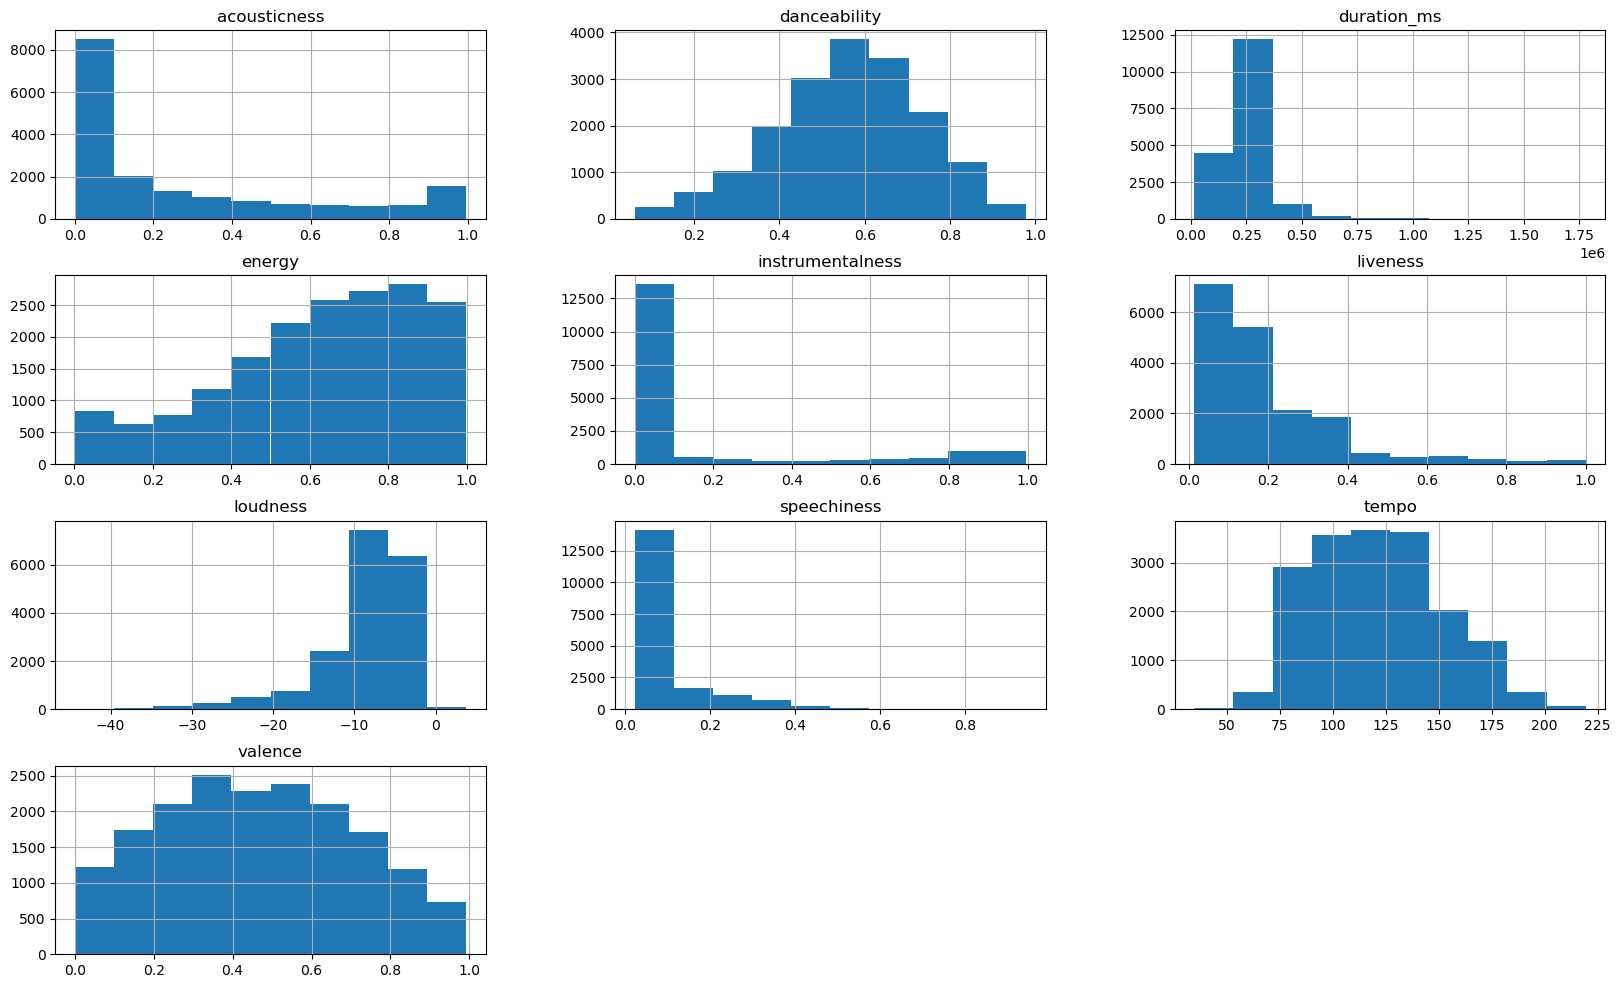

In [175]:
# построим гистограммы распределения тренировочного датасета
train.hist(figsize=(20, 12));

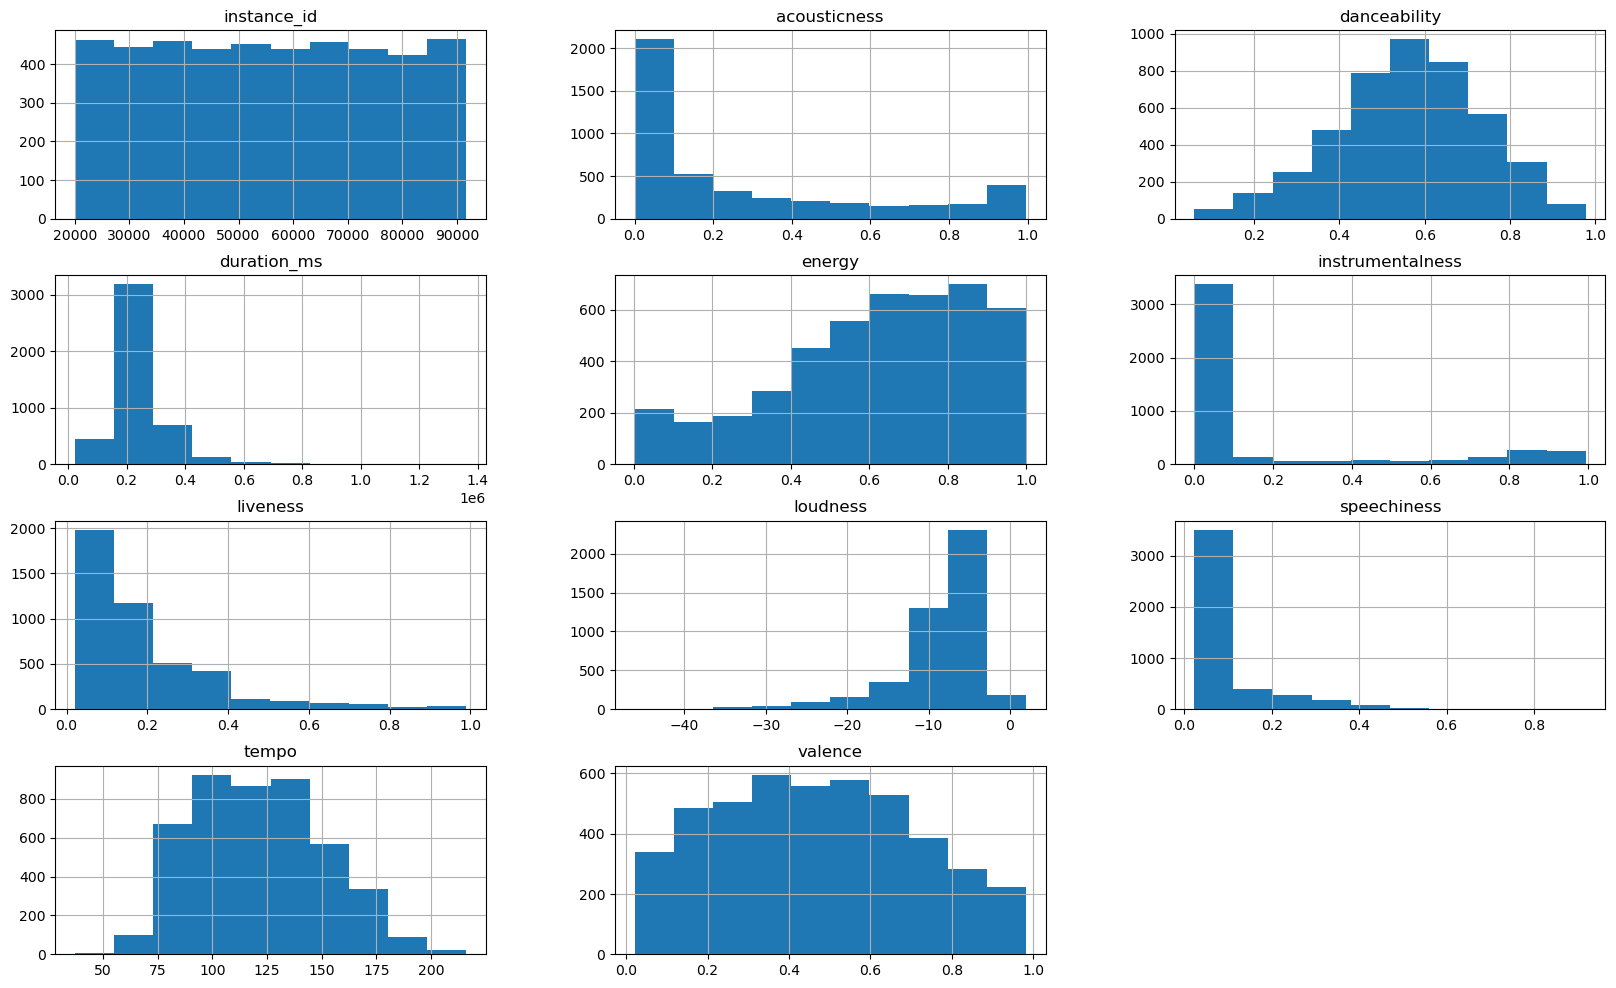

In [176]:
# построим гистограммы распределения тестового датасета
test.hist(figsize=(20, 12));

In [ ]:
phik_overview = train.phik_matrix() # type: ignore

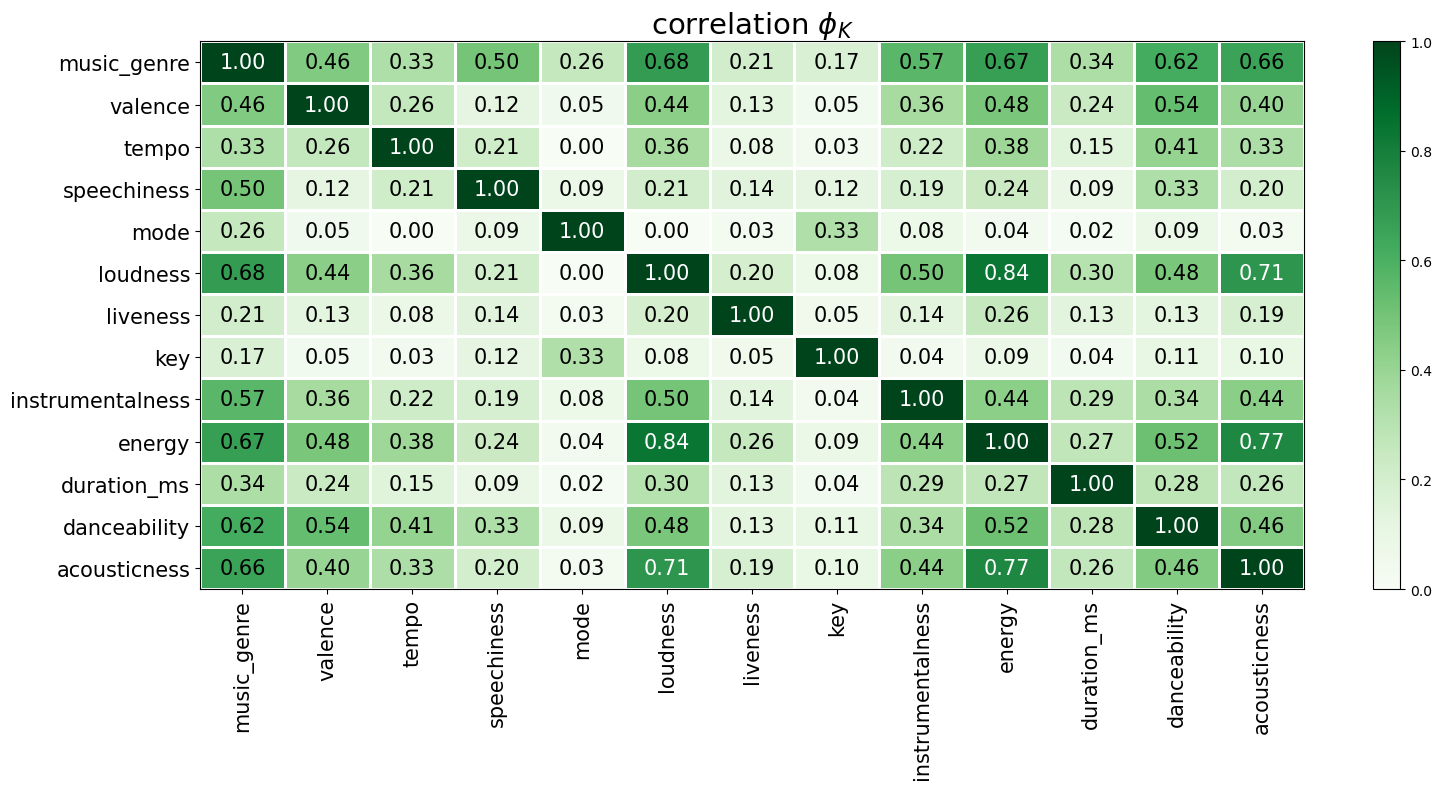

In [178]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(16, 8))
plt.tight_layout()

In [ ]:
significance_overview = train.significance_matrix() # type: ignore

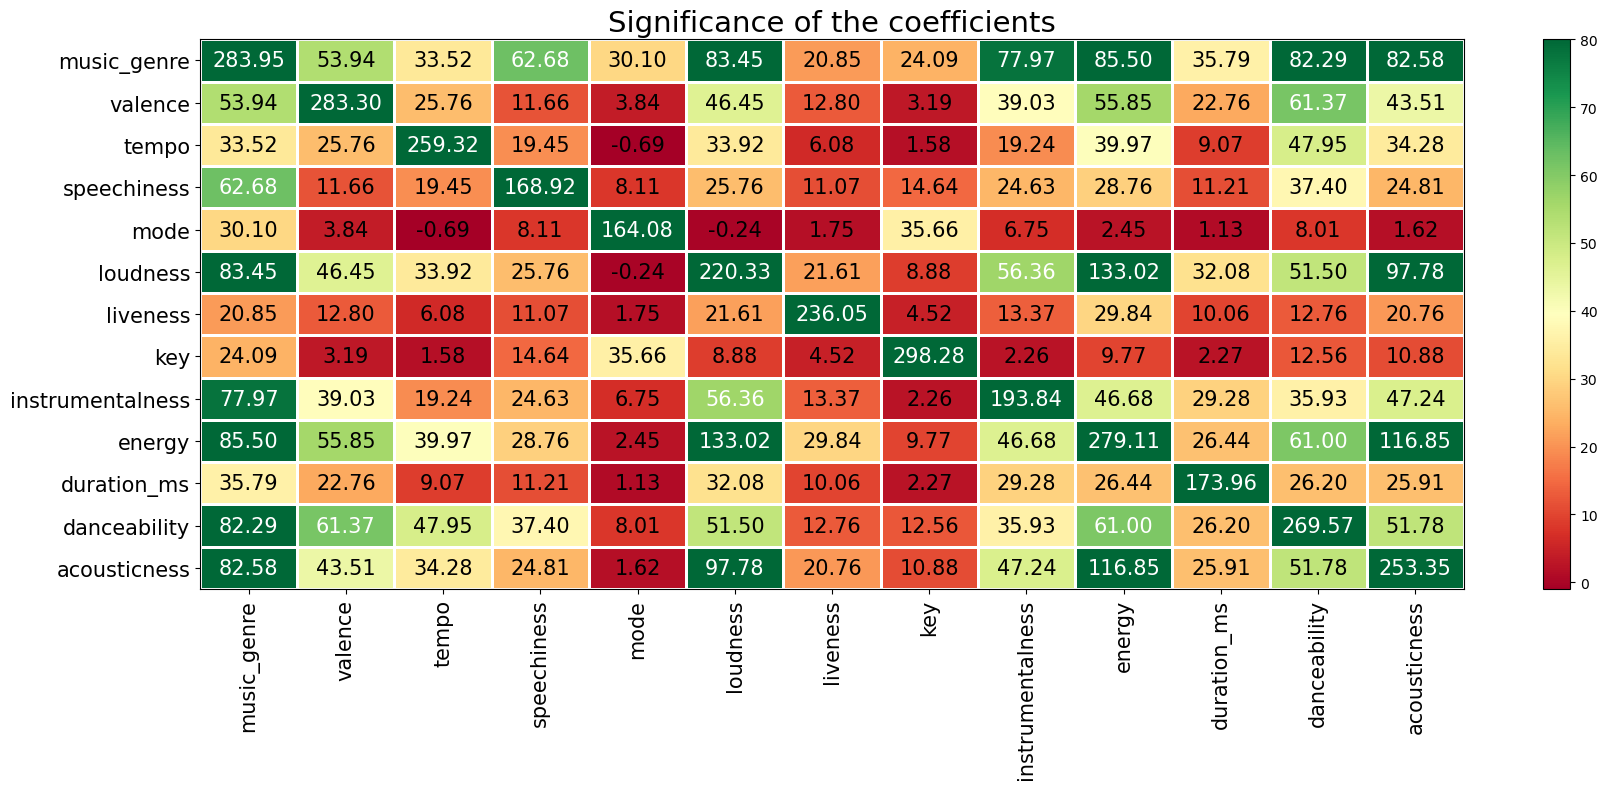

In [183]:
plot_correlation_matrix(significance_overview.fillna(0).values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=-1, vmax=80, title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1.5, figsize=(18, 8))
plt.tight_layout()

In [185]:
global_correlation, global_labels = train.global_phik() # type: ignore

interval columns not set, guessing: ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']


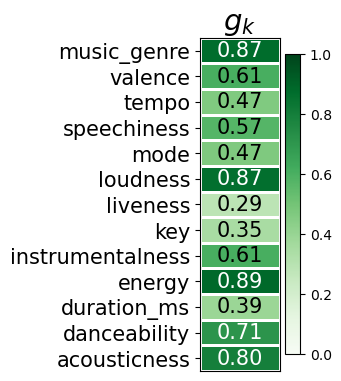

In [186]:
plot_correlation_matrix(global_correlation, 
                        x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(3.5,4),
                        color_map="Greens", title=r"$g_k$",
                        fontsize_factor=1.5)
plt.tight_layout()

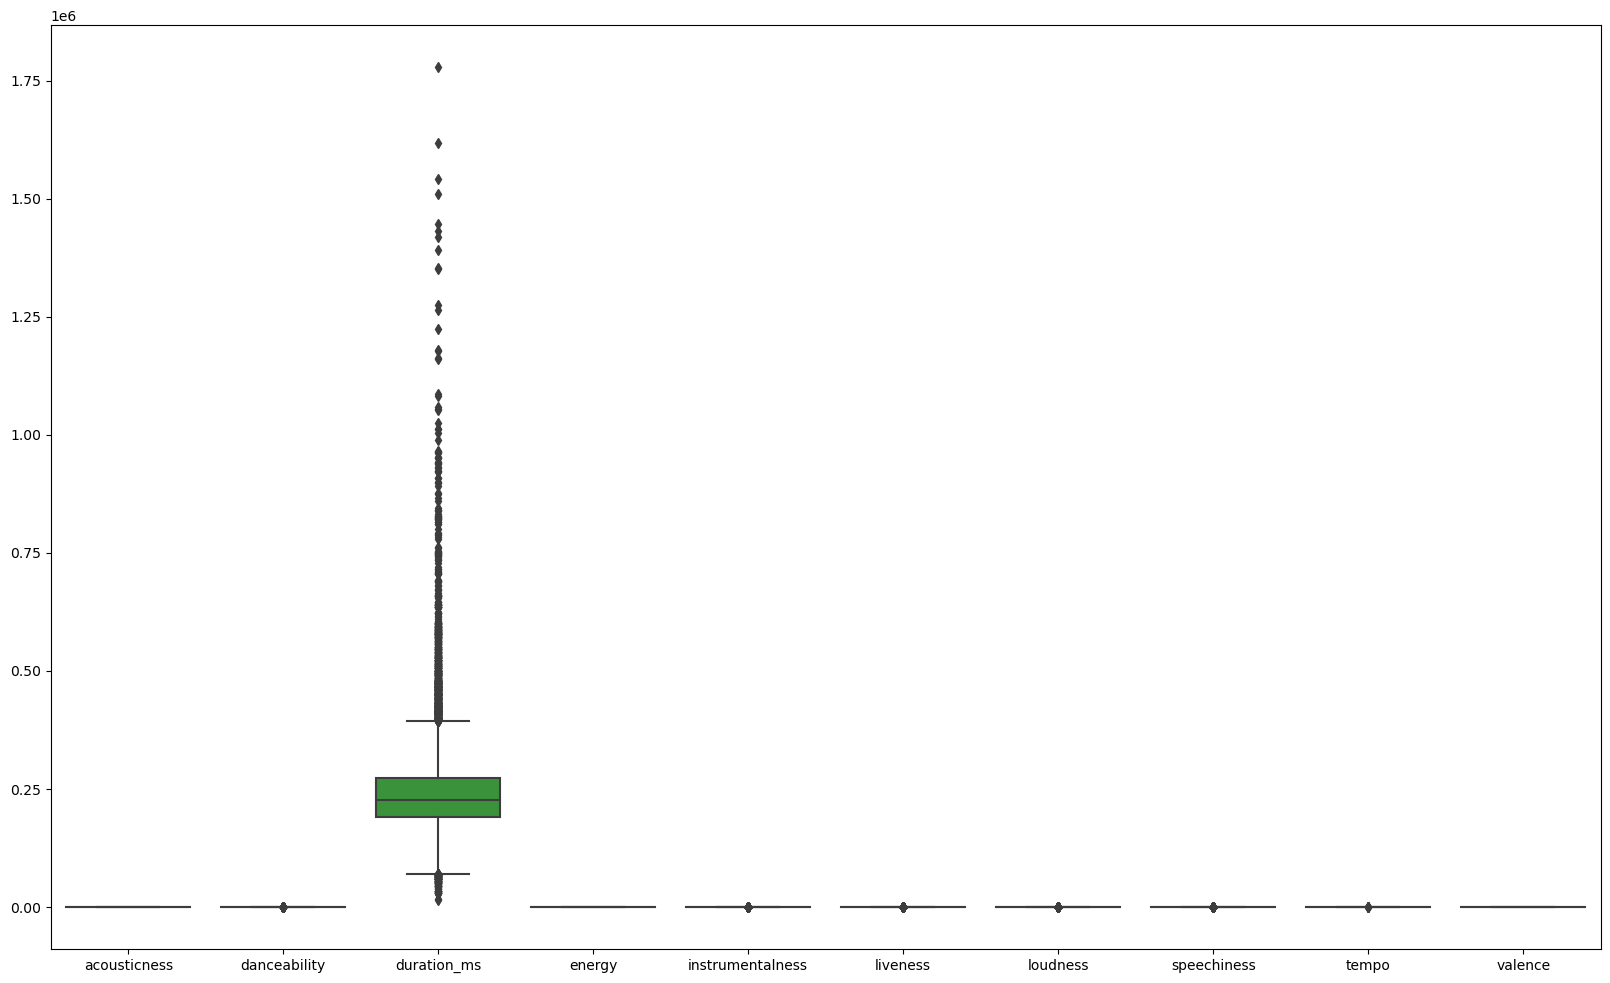

In [137]:
# построим график свечей для тренировочного датасета
plt.figure(figsize=(20, 12))
sns.boxplot(data=train);

In [138]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17982 entries, 0 to 20393
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      17982 non-null  float64
 1   danceability      17982 non-null  float64
 2   duration_ms       17982 non-null  float64
 3   energy            17982 non-null  float64
 4   instrumentalness  17982 non-null  float64
 5   key               17982 non-null  object 
 6   liveness          17982 non-null  float64
 7   loudness          17982 non-null  float64
 8   mode              17982 non-null  object 
 9   speechiness       17982 non-null  float64
 10  tempo             17982 non-null  float64
 11  valence           17982 non-null  float64
 12  music_genre       17982 non-null  object 
dtypes: float64(10), object(3)
memory usage: 1.9+ MB


In [139]:
train['key'].value_counts() 

G          2038
C#         1893
C          1883
D          1853
A          1765
F          1409
B          1345
E          1333
G#         1108
A#         1102
F#         1051
unknown     656
D#          546
Name: key, dtype: int64

In [140]:
train['mode'].value_counts() 

Major      11287
Minor       6258
unknown      437
Name: mode, dtype: int64

In [141]:
train['music_genre'].value_counts() 

Blues          2538
Alternative    2280
Electronic     2273
Rap            2126
Rock           1901
Country        1860
Anime          1691
Classical      1206
Jazz           1108
Hip-Hop         999
Name: music_genre, dtype: int64

## Подготовка данных к обучению моделей

### Тестируем pipeline

In [189]:
num_cols = ['duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
cat_cols = ['key', 'mode']

In [191]:
X = train[num_cols+cat_cols]
y = train['music_genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [192]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14385, 12), (3597, 12), (14385,), (3597,))

In [194]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale',MinMaxScaler())
])
cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one-hot',OneHotEncoder(handle_unknown='ignore', sparse=False))
])

In [196]:
col_trans = ColumnTransformer(transformers=[
    ('num_pipeline',num_pipeline,num_cols),
    ('cat_pipeline',cat_pipeline,cat_cols)
    ],
    remainder='drop',
    n_jobs=-1)

In [197]:
clf = LogisticRegression(random_state=0)
clf_pipeline = Pipeline(steps=[
    ('col_trans', col_trans),
    ('model', clf)
])

In [198]:
set_config(display='diagram')
display(clf_pipeline)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   MinMaxScaler())]),
                                                  ['duration_ms',
                                                   'acousticness',
                                                   'danceability', 'energy',
                                                   'instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'tempo',
                                                   'valence']),
                                                 ('cat_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one-hot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['key', 'mode'])])),
                ('model', LogisticRegression(random_state=0))])

In [200]:
clf_pipeline.fit(X_train, y_train)
# preds = clf_pipeline.predict(X_test)
score = clf_pipeline.score(X_test, y_test)
print(f"Model score: {score}") # accuracy

/Users/sergejvorobev/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/sergejvorobev/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model score: 0.39922157353350013


In [144]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17982 entries, 0 to 20393
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      17982 non-null  float64
 1   danceability      17982 non-null  float64
 2   duration_ms       17982 non-null  float64
 3   energy            17982 non-null  float64
 4   instrumentalness  17982 non-null  float64
 5   key               17982 non-null  object 
 6   liveness          17982 non-null  float64
 7   loudness          17982 non-null  float64
 8   mode              17982 non-null  object 
 9   speechiness       17982 non-null  float64
 10  tempo             17982 non-null  float64
 11  valence           17982 non-null  float64
 12  music_genre       17982 non-null  object 
dtypes: float64(10), object(3)
memory usage: 1.9+ MB


In [145]:
ohe_key = pd.get_dummies(train['key'], prefix='key', drop_first=True)
ohe_mode = pd.get_dummies(train['mode'], prefix='mode', drop_first=True)
train = pd.concat([train, ohe_key, ohe_mode], axis=1)
train = train.drop(['key', 'mode'], axis=1)

In [146]:
ohe_key = pd.get_dummies(test['key'], prefix='key', drop_first=True)
ohe_mode = pd.get_dummies(test['mode'], prefix='mode', drop_first=True)
test = pd.concat([test, ohe_key, ohe_mode], axis=1)
test = test.drop(['key', 'mode'], axis=1)

In [147]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17982 entries, 0 to 20393
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      17982 non-null  float64
 1   danceability      17982 non-null  float64
 2   duration_ms       17982 non-null  float64
 3   energy            17982 non-null  float64
 4   instrumentalness  17982 non-null  float64
 5   liveness          17982 non-null  float64
 6   loudness          17982 non-null  float64
 7   speechiness       17982 non-null  float64
 8   tempo             17982 non-null  float64
 9   valence           17982 non-null  float64
 10  music_genre       17982 non-null  object 
 11  key_A#            17982 non-null  uint8  
 12  key_B             17982 non-null  uint8  
 13  key_C             17982 non-null  uint8  
 14  key_C#            17982 non-null  uint8  
 15  key_D             17982 non-null  uint8  
 16  key_D#            17982 non-null  uint8 

In [148]:
features = train.drop(['music_genre'], axis=1)
target = train['music_genre']

In [149]:
scaler = StandardScaler()
scaler.fit(features)
features = pd.DataFrame(scaler.transform(features), columns=features.columns)

print(features.shape) 

(17982, 24)


In [150]:
features.head(10)

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,...,key_D,key_D#,key_E,key_F,key_F#,key_G,key_G#,key_unknown,mode_Minor,mode_unknown
0,0.639026,0.629892,-0.624238,-1.094146,-0.467361,-0.502575,-1.511831,-0.459726,-0.640692,-0.062653,...,2.950299,-0.176959,-0.282957,-0.291578,-0.24915,-0.357523,-0.256248,-0.194582,-0.730600,-0.157821
1,-0.098030,-0.638770,-0.578483,0.173798,-0.524386,-0.544513,0.027463,-0.573442,-0.255932,0.303428,...,-0.338949,-0.176959,-0.282957,-0.291578,-0.24915,-0.357523,-0.256248,-0.194582,1.368737,-0.157821
2,-0.144679,-0.627131,-0.718251,0.706414,-0.524551,-0.107154,0.604380,2.866703,-1.312433,-0.498659,...,-0.338949,-0.176959,3.534101,-0.291578,-0.24915,-0.357523,-0.256248,-0.194582,1.368737,-0.157821
3,-0.680212,1.659953,0.124736,0.980672,-0.524541,0.755583,0.680889,-0.110385,-0.159272,2.059793,...,-0.338949,-0.176959,-0.282957,-0.291578,-0.24915,-0.357523,3.902466,-0.194582,1.368737,-0.157821
4,-0.147789,1.048900,-0.494735,-0.203802,-0.524545,-0.137110,0.545176,-0.435139,-1.460121,0.484412,...,-0.338949,-0.176959,-0.282957,-0.291578,-0.24915,-0.357523,-0.256248,-0.194582,-0.730600,-0.157821
5,-0.536532,-1.476785,1.522983,-0.144181,0.680986,-0.520548,-0.575685,-0.580613,0.820191,0.126557,...,2.950299,-0.176959,-0.282957,-0.291578,-0.24915,-0.357523,-0.256248,-0.194582,-0.730600,-0.157821
6,-0.853019,0.542599,-0.260506,0.241369,-0.524474,-0.670928,-0.591351,-0.588809,0.101338,-0.223070,...,-0.338949,-0.176959,-0.282957,-0.291578,-0.24915,-0.357523,-0.256248,-0.194582,1.368737,-0.157821
7,2.110029,0.170148,0.674471,-2.056034,0.635494,-0.639774,-1.718224,-0.474069,0.321060,-0.288883,...,-0.338949,5.651023,-0.282957,-0.291578,-0.24915,-0.357523,-0.256248,-0.194582,-0.730600,-0.157821
8,-0.247308,0.496043,0.404434,-0.124308,-0.524168,-0.418698,0.023091,-0.589833,-1.559414,0.332221,...,-0.338949,-0.176959,-0.282957,-0.291578,-0.24915,-0.357523,-0.256248,-0.194582,1.368737,-0.157821
9,-0.753295,-0.144108,-0.069182,1.334424,0.102588,-0.244952,1.055420,0.305547,1.290088,-0.144918,...,-0.338949,-0.176959,-0.282957,-0.291578,-0.24915,-0.357523,-0.256248,-0.194582,-0.730600,-0.157821


In [151]:
"""model = LogisticRegression(solver='liblinear')
model.fit(features, target)
prediction = model.predict(test)

SyntaxError: incomplete input (4271036827.py, line 1)

In [ ]:
"""print('Disbalanced logistic regression')
print()
print('Confusion matrix')
print(confusion_matrix(submit, prediction))
print('Recall:', recall_score(submit, prediction, average='weighted'))
print('Precision:', precision_score(submit, prediction, average='weighted'))
print('Accuracy:', accuracy_score(submit, prediction))
print('F1:', f1_score(submit, prediction, average='weighted'))"""

Disbalanced logistic regression

Confusion matrix
[[  0   0   0 438   0   1   0   0   0   0]
 [  0   0   0 461   0   1   0   0   0   0]
 [  0   0   0 438   0   0   0   0   0   0]
 [  0   0   0 453   0   1   0   0   0   0]
 [  0   0   0 473   0   1   0   0   0   0]
 [  0   0   0 464   0   0   0   0   0   0]
 [  0   0   0 449   0   1   0   0   0   0]
 [  0   0   0 437   0   0   0   0   0   0]
 [  0   0   0 444   0   1   0   0   0   0]
 [  0   0   0 416   0   1   0   0   0   0]]
Recall: 0.10111607142857143
Precision: 0.010263066494203317
Accuracy: 0.10111607142857143
F1: 0.018634745860999162


/Users/sergejvorobev/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# импортируем catboostclassifier
#from catboost import CatBoostClassifier


In [ ]:
"""model = CatBoostClassifier(iterations=2,
                           depth=2,
                           learning_rate=1,
                           loss_function='MultiClass',
                           verbose=True)
# train the model
model.fit(features, target)
# make the prediction using the resulting model
preds_class = model.predict(test)

model.get_best_score()"""

0:	learn: 2.0897299	total: 24.5ms	remaining: 24.5ms
1:	learn: 2.2039404	total: 35.8ms	remaining: 0us


{'learn': {'MultiClass': 2.089729913087933}}